### Topic Analysis using LDA Topic Model (Community Dataset #1: week 36 (2020) - week 53 (2020) - weekly dataset)

#### Import core libraries

In [2]:
# Import Core library
import sys
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, nltk, datetime as dt, seaborn as sns
import emoji
import little_mallet_wrapper
import plotly.express as px
import wordcloud
import openpyxl
from pprint import pprint
from cleantext import clean

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
[nltk_data] Downloading package stopwords to C:\Users\Ivory-
[nltk_data]     UALR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Import Dataset

In [154]:
week36 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week36.xlsx")
week37 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week37.xlsx")
week38 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week38.xlsx")
week39 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week39.xlsx")
week40 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week40.xlsx")
week41 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week41.xlsx")
week42 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week42.xlsx")
week43 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week43.xlsx")
week44 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week44.xlsx")
week45 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week45.xlsx")
week46 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week46.xlsx")
week47 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week47.xlsx")
week48 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week48.xlsx")
week49 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week49.xlsx")
week50 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week50.xlsx")
week51 = (r"1st_analysis_LDAmodel\weekly_datasets\split_by_week51.xlsx")

# Import Dataset
df = pd.read_excel(week51)

In [ ]:
df.tail(2)

#### Importing Dataset (Cummulative Analysis)

In [4]:
# Import multiple files and convert to dataframes (cumulative models)
import glob

path = r".\prob_dist (cummulative)\week"
excel_files = glob.glob(path + "\*.xlsx")

df_list = (pd.read_excel(file) for file in excel_files)

dataframes_list = []
for file in range(len(excel_files)):
    temp_df = pd.read_excel(excel_files[file])
    dataframes_list.append(temp_df)

<>:5: DeprecationWarning: invalid escape sequence \*
<>:5: DeprecationWarning: invalid escape sequence \*
C:\Users\IVORY-~1\AppData\Local\Temp/ipykernel_18324/672462022.py:5: DeprecationWarning: invalid escape sequence \*
  excel_files = glob.glob(path + "\*.xlsx")


In [5]:
print(len(dataframes_list))

16


In [14]:
# Assign each cummulated excel file to a dataframe
df36, df36_37, df36_38, df36_39, df36_40, df36_41, df36_42, df36_43, df36_44, df36_45, df36_46, df36_47, df36_48, df36_49, df36_50, df36_51 = dataframes_list[:]

#### Process Dataset

In [16]:
# Function to remove twitter specific characters
def get_url_patern():
    return re.compile(
        r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'
        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')

def get_hashtags_pattern():
    return re.compile(r'#\w*')

def get_single_letter_words_pattern():
    return re.compile(r'(?<![\w\-])\w(?![\w\-])')

def get_blank_spaces_pattern():
    return re.compile(r'\s{2,}|\t')

def get_twitter_reserved_words_pattern():
    return re.compile(r'(RT|rt|FAV|fav|VIA|via)')

def get_mentions_pattern():
    return re.compile(r'@\w*')

def process_text(word):
  word=re.sub(pattern=get_url_patern(), repl="", string=word)
  word=re.sub(pattern=get_mentions_pattern(), repl="", string=word)
  word=re.sub(pattern=get_hashtags_pattern(), repl="", string=word)
  word=re.sub(pattern=get_twitter_reserved_words_pattern(), repl='', string=word)
  word=re.sub(r'http\S+', "", word)  # remove http links
  word=re.sub(r'bit.ly/\S+', "", word)  # rempve bitly links
  word=word.strip('[link]')  # remove [links]
  word=re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', "", word)  # remove retweet
  word=re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', "", word)  # remove tweeted at
  word=word.encode('ascii', 'ignore').decode('ascii')
#   word=clean(word, no_emoji=True)
  return word


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

<>:30: DeprecationWarning: invalid escape sequence \s
<>:30: DeprecationWarning: invalid escape sequence \s
C:\Users\IVORY-~1\AppData\Local\Temp/ipykernel_18324/361431163.py:30: DeprecationWarning: invalid escape sequence \s
  word=re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', "", word)  # remove retweet


In [ ]:
# Clean text and remove twitter specific characters
df.text = df.apply(lambda row: process_text(row.text), 1)

# Remove duplicates, punctuations, stop words, digits and turn text to lowercase (with duplicates)
data = [little_mallet_wrapper.process_string(text, numbers='remove') for text in df.text]

# Remove punctuations
data_words = list(sent_to_words(data))
print(data_words[:10])

In [18]:
'''Process text and remove duplicates, punctuations, stop words, digits and turn text to lowercase for cummulated files'''
data_words_list = []

for df in dataframes_list:
    df.text = df.apply(lambda row: process_text(row.text), 1)
    data = [little_mallet_wrapper.process_string(text, numbers='remove') for text in df.text]
    data_words = list(sent_to_words(data))
    data_words_list.append(data_words)

#### N-grams & Lemmatization

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [21]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [22]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 40000000

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [162]:
print(data_lemmatized[:10])

[['thinking', 'approve', 'paicipate', 'criminal', 'behavior', 'constitution', 'matter', 'take', 'lead', 'need', 'do'], ['thank'], [], [], ['exactly'], [], [], [], [], []]


In [23]:
'''Lemmatize words for cummulated files'''
lemmatized_list = []

for data_words in data_words_list:
    
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    nlp.max_length = 40000000
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    lemmatized_list.append(data_lemmatized)

In [163]:
# # Export lemmatized data for document similarity evaluation
# corpus_df = pd.DataFrame(data_lemmatized)
# corpus_df.to_csv('prob_dist/corpus_week51.csv', index=False, header=False)

In [24]:
# Assign each cummulated excel file to a dataframe
corpus36, corpus36_37, corpus36_38, corpus36_39, corpus36_40, corpus36_41, corpus36_42, corpus36_43, corpus36_44, corpus36_45, corpus36_46, corpus36_47, corpus36_48, corpus36_49, corpus36_50, corpus36_51 = lemmatized_list[:]
corpus_list = [corpus36, corpus36_37, corpus36_38, corpus36_39, corpus36_40, corpus36_41, corpus36_42, corpus36_43, corpus36_44, corpus36_45, corpus36_46, corpus36_47, corpus36_48, corpus36_49, corpus36_50, corpus36_51]

In [25]:
# Export lemmatized data for document similarity evaluation (cummulated files)
weeks = ["36", "36_37", "36_38", "36_39", "36_40", "36_41", "36_42", "36_43", "36_44", "36_45", "36_46", "36_47", "36_48", "36_49", "36_50", "36_51"]
for corpus, week in zip(corpus_list, weeks):
    corpus_df = pd.DataFrame(corpus)
    corpus_df.to_csv('.\prob_dist (cummulative)\corpus_docs\corpus_{}.csv'.format(week), index=False, header=False)

<>:5: DeprecationWarning: invalid escape sequence \p
<>:5: DeprecationWarning: invalid escape sequence \p
C:\Users\IVORY-~1\AppData\Local\Temp/ipykernel_18324/2915575910.py:5: DeprecationWarning: invalid escape sequence \p
  corpus_df.to_csv('.\prob_dist (cummulative)\corpus_docs\corpus_{}.csv'.format(week), index=False, header=False)


In [612]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[], [(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1)], [(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)], [(15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)], [(31, 1), (32, 1), (33, 1), (34, 1)], [(35, 1)], [(17, 1), (19, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)], [(27, 1), (42, 1), (43, 1), (44, 1), (45, 1)], [(5, 1), (46, 1), (47, 1), (48, 1)], [(37, 1), (49, 1), (50, 1), (51, 1), (52, 1)]]


#### Building the LDA Model

In [628]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=13, 
                                           random_state=100,
                                           iterations=50,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [614]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.881835228919789

Coherence Score:  0.5262442404280109


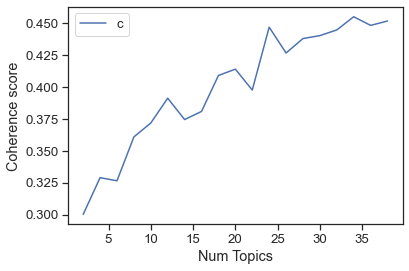

In [615]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=2)

# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [616]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
# NB: From pyLDAvis visualization,
# week36 = optimal number of topics is 4
# week37 = optimal number of topics is 6
# week38 = optimal number of topics is 2
# week39 = optimal number of topics is 2
# week40 = optimal number of topics is 8
# week41 = optimal number of topics is 4
# week42 = optimal number of topics is 2
# week43 = optimal number of topics is 6 (I picked 4)
# week44 = optimal number of topics is 6
# week45 = optimal number of topics is 6
# week46 = optimal number of topics is 10
# week47 = optimal number of topics is 12
# week48 = optimal number of topics is 12
# week49 = optimal number of topics is 14
# week50 = optimal number of topics is 12
# week51 = optimal number of topics is 13

Num Topics = 2  has Coherence Value of 0.3001
Num Topics = 4  has Coherence Value of 0.3289
Num Topics = 6  has Coherence Value of 0.3264
Num Topics = 8  has Coherence Value of 0.3608
Num Topics = 10  has Coherence Value of 0.3717
Num Topics = 12  has Coherence Value of 0.3911
Num Topics = 14  has Coherence Value of 0.3744
Num Topics = 16  has Coherence Value of 0.3808
Num Topics = 18  has Coherence Value of 0.4089
Num Topics = 20  has Coherence Value of 0.4139
Num Topics = 22  has Coherence Value of 0.3975
Num Topics = 24  has Coherence Value of 0.4467
Num Topics = 26  has Coherence Value of 0.4265
Num Topics = 28  has Coherence Value of 0.4378
Num Topics = 30  has Coherence Value of 0.4402
Num Topics = 32  has Coherence Value of 0.4446
Num Topics = 34  has Coherence Value of 0.4549
Num Topics = 36  has Coherence Value of 0.4482
Num Topics = 38  has Coherence Value of 0.4516


In [597]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.017*"love" + 0.013*"good" + 0.013*"election" + 0.011*"step" + 0.010*"let" '
  '+ 0.009*"know" + 0.009*"go" + 0.009*"senator" + 0.008*"call" + '
  '0.008*"legislator"'),
 (1,
  '0.040*"thank" + 0.026*"know" + 0.017*"patriot" + 0.016*"stand" + '
  '0.016*"want" + 0.014*"sure" + 0.011*"man" + 0.011*"world" + 0.008*"true" + '
  '0.007*"liar"'),
 (2,
  '0.073*"vote" + 0.035*"steal" + 0.031*"stop" + 0.027*"election" + '
  '0.018*"trump" + 0.018*"count" + 0.014*"never" + 0.014*"ballot" + '
  '0.014*"way" + 0.011*"get"'),
 (3,
  '0.024*"people" + 0.018*"election" + 0.017*"fraud" + 0.014*"right" + '
  '0.011*"get" + 0.011*"lose" + 0.010*"good" + 0.010*"do" + 0.009*"never" + '
  '0.009*"trump"'),
 (4,
  '0.019*"vote" + 0.017*"think" + 0.012*"call" + 0.011*"election" + '
  '0.011*"citizen" + 0.010*"say" + 0.010*"right" + 0.010*"keep" + 0.010*"time" '
  '+ 0.010*"suppoer"'),
 (5,
  '0.024*"take" + 0.018*"say" + 0.016*"go" + 0.016*"never" + 0.013*"state" + '
  '0.011*"get" + 0.010*"see" +

#### Visualize Topic Distribution & Keywords

In [629]:
topic_dist = pd.DataFrame()

# Code to view the Ist 4 keywords per topic
for index, topic in lda_model.show_topics(formatted=False, num_words= 10):
    words = [w[0] for w in topic]
    topic_distributions_df = ["".join(topic[:4]) for topic in words]
    topic_dist = topic_dist.append(pd.Series([index, words]), ignore_index=True)
    
    # print('Topic: {} \nWords: {}'.format(index, words))
    # print(topic_distributions_df)
    
topic_dist.columns = ['Topic_Number', 'Topic_Words']
# Export topic word distribution per topic to excel file
topic_dist.to_excel(r"1st_analysis_LDAmodel\topic_dist 36-51 (no_duplicate)\topic_dist51_no_duplicate.xlsx", index=False, header=True)

C:\Users\Ivory-UALR\AppData\Local\Temp\ipykernel_17872\3271735155.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_dist = topic_dist.append(pd.Series([index, words]), ignore_index=True)
C:\Users\Ivory-UALR\AppData\Local\Temp\ipykernel_17872\3271735155.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_dist = topic_dist.append(pd.Series([index, words]), ignore_index=True)


In [630]:
topic_dist

,Topic_Number,Topic_Words
0,2,"[stand, call, write, video, truth, legislator,..."
1,10,"[medium, deny, least, think, mean, fraudulent,..."
2,5,"[evidence, system, thing, long, do, believe, n..."
3,3,"[american, fight, hard, bless, woke, great, wo..."
4,1,"[trump, rudy, right, show, ballot, leave, rall..."
5,9,"[thank, make, noise, time, fighting, folk, spr..."
6,11,"[know, little, president, news, back, pay, loo..."
7,0,"[machine, dominion, forensic, event, voting, b..."
8,4,"[people, suppo, get, say, ceifiable, prelimina..."
9,12,"[election, fraud, day, steal, continue, recoun..."


In [631]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\Ivory-UALR\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.363593 -0.016579       1        1  18.140048
4      0.082584  0.038877       2        1  10.551944
0     -0.065523  0.084227       3        1  10.430626
11     0.023593  0.011969       4        1   8.527985
8      0.034140  0.064257       5        1   8.440692
9      0.040899 -0.348130       6        1   7.364172
7      0.062118  0.091276       7        1   6.769803
6      0.041149  0.007306       8        1   5.952035
1      0.038345  0.019172       9        1   5.868202
5      0.005707  0.011976      10        1   4.981942
3      0.027235  0.004566      11        1   4.699042
10     0.035995  0.012401      12        1   4.143067
2      0.037350  0.018682      13        1   4.130442, topic_info=              Term        Freq       Total Category  logprob  loglift
17        election  188.000000  188.000000  Default  30.0000  30.0000
48            vote   94.000000   94.000000  Default  29.0000  29.0000
328       american   51.000000   51.000000  Default  28.0000  28.0000
90          people   71.000000   71.000000  Default  27.0000  27.0000
314          thank   59.000000   59.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1224          home    1.963759    2.794190  Topic13  -5.0292   2.8341
150   overwhelming    1.905776    2.736218  Topic13  -5.0591   2.8251
1528          asap    1.853731    2.684157  Topic13  -5.0868   2.8166
392      recognize    1.793235    2.623679  Topic13  -5.1200   2.8062
80            take    3.472527   26.283070  Topic13  -4.4592   1.1627

[441 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1435      3  0.932907     ability
1010      8  0.628480        able
625       9  0.720794    absentee
318      10  0.859560  absolutely
1216      6  0.879162      accuse
...     ...       ...         ...
154      13  0.918676       write
176       3  0.856586       wrong
221       6  0.920663        year
396       2  0.893752         yet
327      11  0.652335     youtube

[418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 5, 1, 12, 9, 10, 8, 7, 2, 6, 4, 11, 3])

In [632]:
# Export LDA Model
pyLDAvis.save_html(vis, r"1st_analysis_LDAmodel\LDAviz 36-51 (no_duplicate)\week51_LDAviz_no_duplicate.html")